In [219]:
from collections import defaultdict
import csv
import io
import json
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
from scipy import stats
import seaborn as sns
import pickle

## Load data from data folder, and save into all_data.json

In [220]:
bad_ids = ["f99a", "4c3b", "4b49", "88ae", "4c3b", "a8e9", "22f3", "1fa4", "8aed", "0ac7", "5a1c"] + \
          ['7ad7', '9624', '504a', 'b196','5fbc', '641f', '52dc', 'b55a', '56f8'] # Technical Error (off-by-one)

In [221]:
DATA_PATH = "../data" # path to data files
files = [f for f in listdir(DATA_PATH) if f.endswith(".json")]
files.sort()

all_data = defaultdict(dict)

for f in files:
    with io.open(join(DATA_PATH, f), "r", encoding = "utf-8", errors = "ignore") as readfile:

        f_split = f.split("_")
        client_id = f_split[0]
        
        if client_id[-4:] in bad_ids:
            continue

        trial = f_split[1].split(".")[0]
        
        content = readfile.read()
        parsed_data = json.loads(content)

        all_data["client_" + client_id]["trial_" + trial] = parsed_data

keys = list(all_data.keys())
for client in keys:
    try:
        assert all(["trial_" + str(trial) in all_data[client].keys() for t in range(1,4)])
        trial_survey_lens = [len(all_data[client]["trial_" + str(trial)]['survey_responses']) for trial in range(1,4)]
        assert all([t == 20 for t in trial_survey_lens])
    except:
        del all_data[client]

# At this point, all_data = {client_id : { trial_# : { data }}}

with open('all_data.json', 'w') as f:
    json.dump(all_data, f)

## Load all_data.json

In [222]:
with open("all_data.json", "r") as f:
    all_data = json.load(f)

## Helpers

In [239]:
# this is kind of a weird way to do this...
condition_lookup = {
    0: {
        0: 'low competence agent',
        0.5: 'learning agent'
    },
    0.5: {
        0.5: 'high competence agent'
    },
    0.2: {
        0.2: 'low competence agent',
        0.8: 'learning agent'
    },
    0.8: {
        0.8: 'high competence agent'
    }
}

def get_experiment_setting(trial_data):
    """Return important keys that disambiguate the experiment setting"""
    return {key: trial_data[key] for key in ['player2_ability_description',
                                              'player1_initial_ability',
                                              'player1_final_ability']}

def get_condition_str(trial_data):
    """Return plain English version of experiment condition, similar to `get_experiment_setting`"""
    if 'player1_initial_ability' in trial_data and 'player1_final_ability' in trial_data and \
        condition_lookup[trial_data['player1_initial_ability']][trial_data['player1_final_ability']]:
        return condition_lookup[trial_data['player1_initial_ability']][trial_data['player1_final_ability']]

def get_outcomes(trial_data):
    """Return a numpy array of the following format
        [ [round_index, outcome] ...]
       where outcome is a 1, 0.5, or 0 indicating player 1's win, tie, or loss.
    """
    outcomes_by_index = []
    for round in trial_data['rounds']:
        round_index = round['round_index']
        outcome_str = round['player1_outcome']
        outcome_numeric = 1 * int(outcome_str == 'win') + 0.5 * int(outcome_str == 'tie') + 0 * int(outcome_str == 'loss')
        outcomes_by_index.append([round_index, outcome_numeric])
    return np.array(outcomes_by_index)

def get_response_times(trial_data):
    """Return a numpy array of the following format
        [ [round_index, response_time] ...]
        where response_time is the round_begin_ts-game_begin_ts of the round (in seconds).
    """
    game_begin_ts = trial_data['game_begin_ts']
    round_indices = []
    response_times = []
    for round in trial_data['rounds']:
        round_index = round['round_index']
        round_indices.append(round_index)
        round_begin_ts = round['round_begin_ts']
        response_times.append(round_begin_ts)
    response_times = (np.array(response_times).astype(np.datetime64) - np.array([game_begin_ts]).astype(np.datetime64)) / np.timedelta64(1, 's')
    round_indices = np.array(round_indices)
    return np.column_stack((round_indices, response_times))

def get_responses(trial_data):
    """Return a numpy array of the following format
        [ [round_index, participant's estimate of agent's win prob, participant's estimate of their own win prob] ...]
    """
    responses_by_index = []
    for round_obj in trial_data['survey_responses']:
        round_index = round_obj['round_index']
        # Continuous sliders: divide by 100 to get a probability
        # est_agent_prob_winning = round['slider_1'] / 100
        # est_you_prob_winning = round['slider_2'] / 100
        # Discrete sliders: keep the raw values
        est_agent_prob_winning = float(round_obj['slider_1'])
        est_you_prob_winning = float(round_obj['slider_2'])
        responses_by_index.append([round_index, est_agent_prob_winning, est_you_prob_winning])
    return np.array(responses_by_index)

def get_response_df(all_data):
    """Return pandas data frame with response data in long form"""
    response_df = pd.DataFrame(columns=['participant_id', 'opponent_ability', 'agent_ability', 
        'trial', 'agent_win_response', 'participant_win_response'])
    # NB: this is probably not the most efficient way to do this...
    for client_id, client_data in all_data.items():
        for trial_id, trial_data in client_data.items():
            responses = get_responses(trial_data)
            response_times = get_response_times(trial_data)
            opponent = trial_data['player2_ability_description']
            agent = get_condition_str(trial_data)
            for resp, resp_time in zip(responses, response_times):
                response_df = response_df.append({
                    'participant_id': client_id, 
                    'opponent_ability': opponent, 
                    'agent_ability': agent, 
                    'trial': resp[0],
                    'agent_win_response': resp[1], 
                    'participant_win_response': resp[2]},
                    ignore_index=True)
    return response_df

def write_outcomes_and_ratings(all_data):
    """Write data in an easy format for model files"""
    all_data_dict = defaultdict(lambda : defaultdict(lambda : defaultdict(dict)))
    for client_id, client_data in all_data.items():
        for trial_id, trial_data in client_data.items():
            responses = get_responses(trial_data)
            outcomes = get_outcomes(trial_data)
            opponent = trial_data['player2_ability_description']
            agent = get_condition_str(trial_data)
            all_data_dict[opponent][client_id][agent]['outcomes'] = outcomes[:, 1]
            all_data_dict[opponent][client_id][agent]['responses'] = responses[:, 1]

    all_expert_client_ids = sorted(list(all_data_dict['expert'].keys()))
    expert_client_ids = all_expert_client_ids[:-3]
    expert_heldout_client_ids = all_expert_client_ids[-3:]
    all_novice_client_ids = sorted(list(all_data_dict['novice'].keys()))
    novice_client_ids = all_novice_client_ids[:-6]
    novice_heldout_client_ids = all_novice_client_ids[-6:]

    for id_list, name in zip([expert_client_ids, expert_heldout_client_ids, novice_client_ids, novice_heldout_client_ids], \
                            ['expert', 'expert_heldout', 'novice', 'novice_heldout']):
        data = {id: all_data_dict[name[:6]][id] for id in id_list}
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(data, f)

In [240]:
write_outcomes_and_ratings(all_data)

## Analysis: overall participant summary

In [225]:
response_df = get_response_df(all_data)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


*How many participants in each opponent ability category ("expert", "novice")?*

In [226]:
response_df.groupby('opponent_ability')['participant_id'].nunique()

opponent_ability
expert    17
novice    37
Name: participant_id, dtype: int64

In [227]:
response_df[ response_df['trial'] % 5 != 0 ]['participant_id'].value_counts()

Series([], Name: participant_id, dtype: int64)

## Analysis: summary of main effects

**Questions:**

- *Do we see differences in overall attribution of agent win probabilities across conditions?*
- *Do we see differences in ratings of participant win probabilities across opponent types?*

In [228]:
response_summary_overall = response_df.groupby(
    ['agent_ability']
    )['agent_win_response'].agg(
        [np.mean, np.std, stats.sem]
    ).reset_index()
response_summary_overall



,agent_ability,mean,std,sem
0,high competence agent,6.554630,1.799695,0.054763
1,learning agent,5.278704,1.699128,0.051703
2,low competence agent,4.298148,1.745641,0.053118


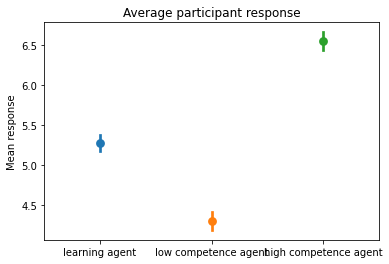

In [229]:

# Bootstrapped CI estimates
sns.pointplot(x='agent_ability',
                y='agent_win_response',
                hue='agent_ability',
                data=response_df)


# sns.pointplot(x='agent_ability',
#                 y='mean',
#                 hue='agent_ability',
#                 data=response_summary_overall)
# plt.errorbar(response_summary_overall.get('agent_ability'), 
#     response_summary_overall.get('mean'), 
#     yerr=response_summary_overall.get('sem'), 
#     fmt='.', ecolor='0.5', color='0.5')
# plt.axhline(4.0, ls='--', c='black')

plt.title('Average participant response')
# plt.xlabel('Agent ability')
# plt.xticks([])
plt.xlabel('')
plt.ylabel('Mean response')
plt.legend([],[], frameon=False)

In [230]:
participant_response_summary = response_df.groupby(
    ['opponent_ability', 'participant_id']
    )['participant_win_response'].agg(
        [np.mean, np.std]
    ).reset_index()

participant_response_summary.head()

,opponent_ability,participant_id,mean,std
0,expert,client_06dcc247-140a-4d88-b8ae-ee2791344c02,5.166667,0.418499
1,expert,client_0d2f0ff5-af9a-4936-b34e-011261da283a,4.550000,0.790301
2,expert,client_349120fb-dd0a-4b53-a821-c3f568ab0544,6.133333,2.273403
3,expert,client_378f690a-6c54-4469-9faf-245591f689ee,4.583333,1.768765
4,expert,client_6efc85a6-4992-493d-ad7d-aacdae2ae9b2,4.950000,1.545085


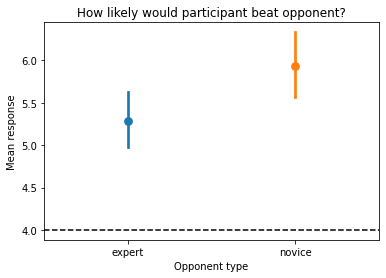

In [231]:
sns.pointplot(x='opponent_ability', 
              y='mean',
              hue='opponent_ability',
              data=participant_response_summary)
plt.axhline(4.0, ls='--', c='black')
plt.title('How likely would participant beat opponent?')
plt.xlabel('Opponent type')
plt.ylabel('Mean response')
plt.legend([],[], frameon=False)

In [232]:
# n_trials = 100.0
# response_df['second_half'] = (response_df['trial'] / n_trials > 0.5)


# response_df_split = response_df.groupby(
#     ['agent_ability', 'second_half']
#     )['agent_win_response'].agg(
#         [np.mean, np.std, stats.sem]
#     ).reset_index()

# response_df_split



In [233]:
n_trials = 100.0
response_df['quarter'] = (response_df['trial'] - 5) // (n_trials / 4)
# response_df


response_df_split = response_df.groupby(
    ['agent_ability', 'quarter']
    )['agent_win_response'].agg(
        [np.mean, np.std, stats.sem]
    ).reset_index()

response_df_split


,agent_ability,quarter,mean,std,sem
0,high competence agent,-1.0,5.000000,0.000000,0.000000
1,high competence agent,0.0,6.264151,1.894479,0.116377
2,high competence agent,1.0,6.807547,1.675565,0.102929
3,high competence agent,2.0,6.664151,1.724500,0.105935
4,high competence agent,3.0,6.600000,1.876489,0.115272
5,learning agent,-1.0,5.000000,0.000000,0.000000
6,learning agent,0.0,4.524528,1.640042,0.100747
7,learning agent,1.0,4.950943,1.525493,0.093710
8,learning agent,2.0,5.516981,1.495161,0.091847
9,learning agent,3.0,6.143396,1.747889,0.107372


In [234]:
# sns.pointplot(x='second_half',
#                 y='mean',
#                 hue='agent_ability',
#                 data=response_df_split)
# plt.axhline(4.0, ls='--', c='black')
# plt.errorbar(response_df_split.get('second_half'), 
#     response_df_split.get('mean'), 
#     yerr=response_df_split.get('sem'), 
#     fmt='.', ecolor='0.5', color='0.5')
# plt.title('Average participant response')
# plt.xlabel('Trial split halves')
# plt.xticks([])
# plt.ylabel('Mean response')

Text(0, 0.5, 'Mean response')

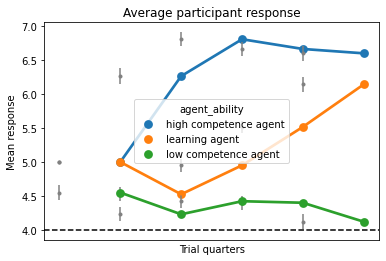

In [235]:
sns.pointplot(x='quarter',
                y='mean',
                hue='agent_ability',
                data=response_df_split)
plt.axhline(4.0, ls='--', c='black')
plt.errorbar(response_df_split.get('quarter'), 
    response_df_split.get('mean'), 
    yerr=response_df_split.get('sem'), 
    fmt='.', ecolor='0.5', color='0.5')
plt.title('Average participant response')
plt.xlabel('Trial quarters')
plt.xticks([])
plt.ylabel('Mean response')


In [236]:
# SEM errorbars
response_summary = response_df.groupby(
    ['agent_ability', 'trial']
    )['agent_win_response'].agg(
        [np.mean, np.std, stats.sem, 'count']
    ).reset_index()

pd.DataFrame(response_summary)

,agent_ability,trial,mean,std,sem,count
0,high competence agent,0.0,5.000000,0.000000,0.000000,20
1,high competence agent,5.0,5.245283,1.697347,0.233149,53
2,high competence agent,10.0,6.207547,1.609569,0.221091,53
3,high competence agent,15.0,6.566038,1.748730,0.240206,53
4,high competence agent,20.0,6.509434,2.099658,0.288410,53
...,...,...,...,...,...,...
58,low competence agent,80.0,4.113208,1.728276,0.237397,53
59,low competence agent,85.0,4.094340,1.944065,0.267038,53
60,low competence agent,90.0,4.150943,1.812311,0.248940,53
61,low competence agent,95.0,4.207547,1.944998,0.267166,53


Text(0, 0.5, 'Mean response')

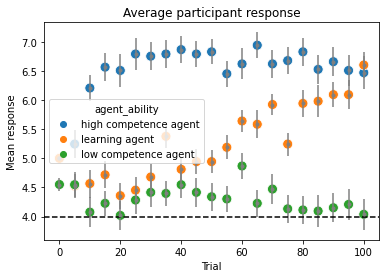

In [237]:




# Boostratpped 95% CIs
# sns.pointplot(x='trial', 
#               y='agent_win_response',
#               hue='agent_ability',
#               data=response_df,
#               dodge=True)
# plt.title('Average participant response')
# plt.xlabel('Trial')
# plt.ylabel('Mean response')

sns.scatterplot(x='trial',
                y='mean',
                hue='agent_ability',
                s=100,
                data=response_summary)
plt.axhline(4.0, ls='--', c='black')

plt.errorbar(response_summary.get('trial'), response_summary.get('mean'), yerr=response_summary.get('sem'), fmt='.', ecolor='0.5', color='0.5')
plt.title('Average participant response')
plt.xlabel('Trial')
plt.ylabel('Mean response')


## Analysis: Individual condition effects

**Questions:**

- *Do people differentiate between the agents at an individual level?*

- *Do people detect that the learning agent is improving?*

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


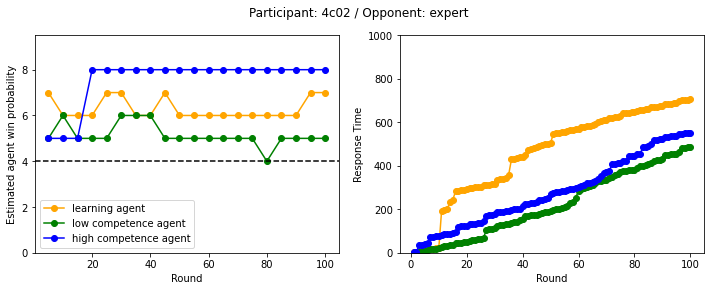

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


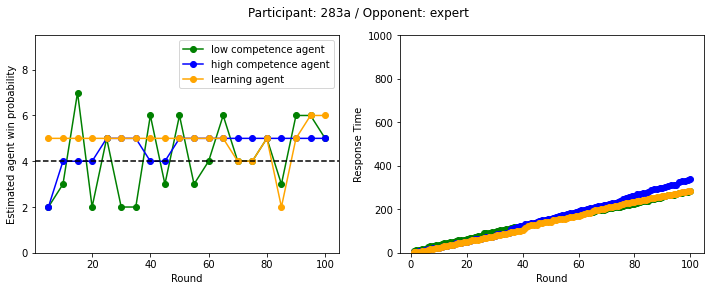

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


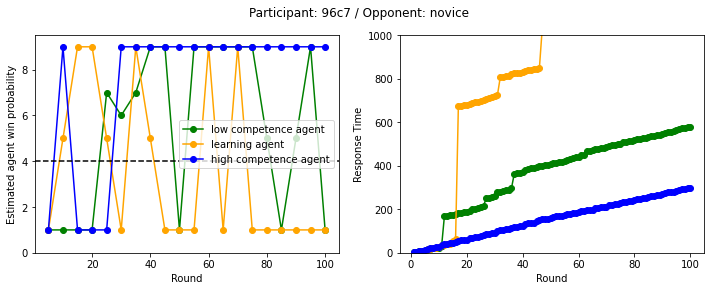

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


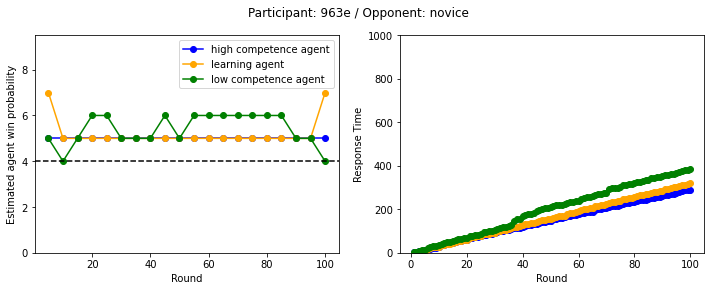

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


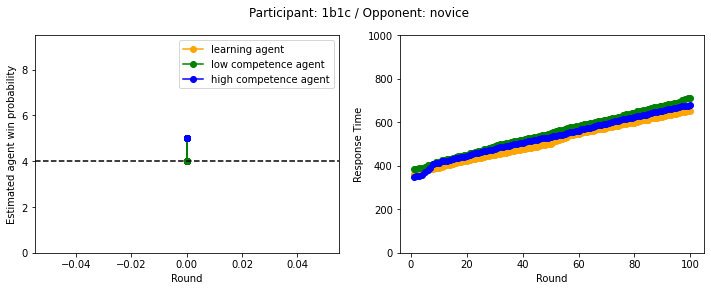

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


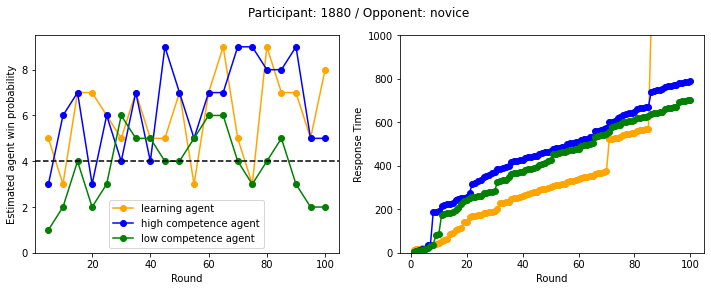

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


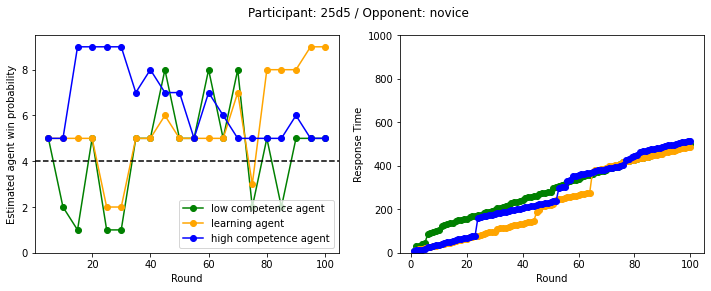

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


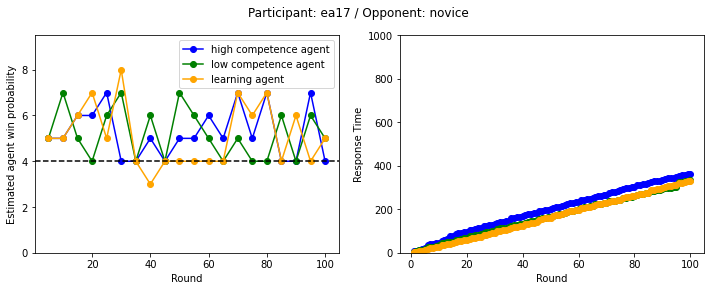

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


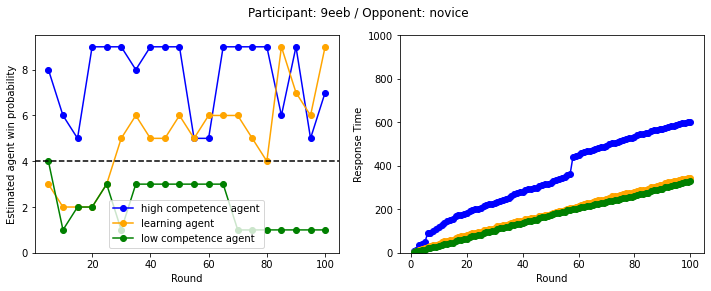

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


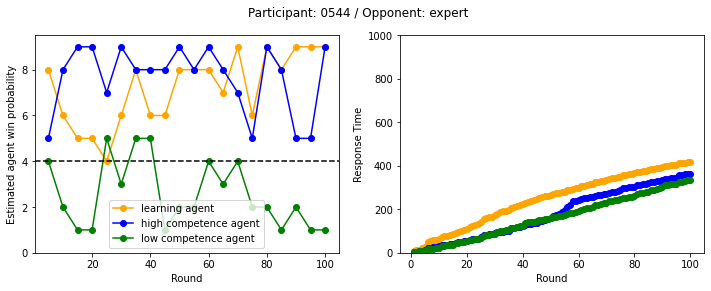

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


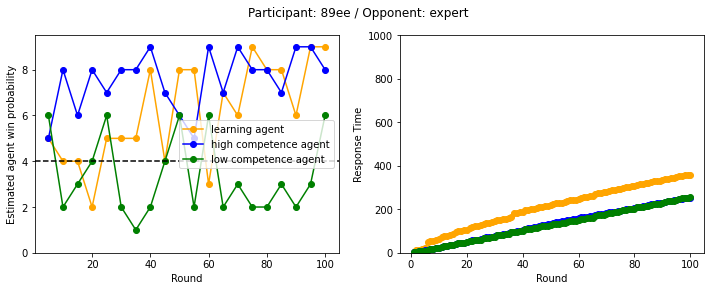

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


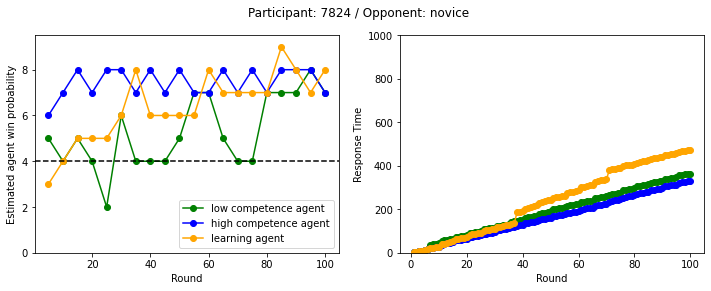

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


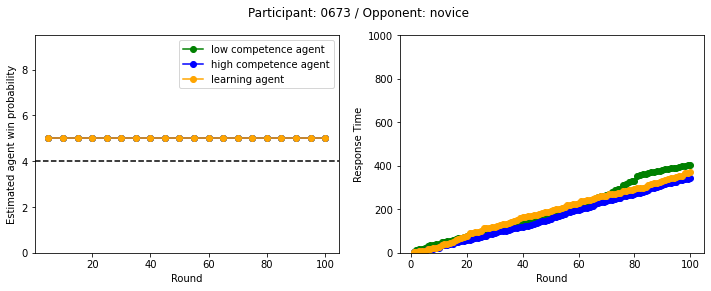

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


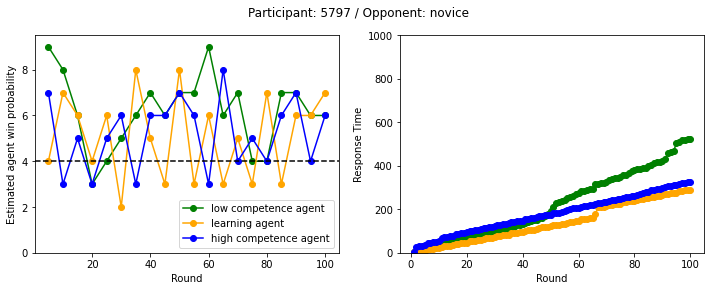

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


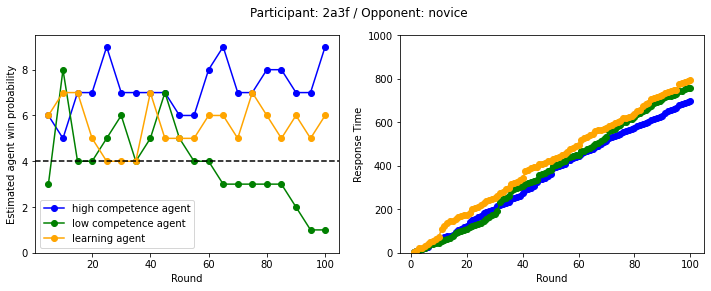

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


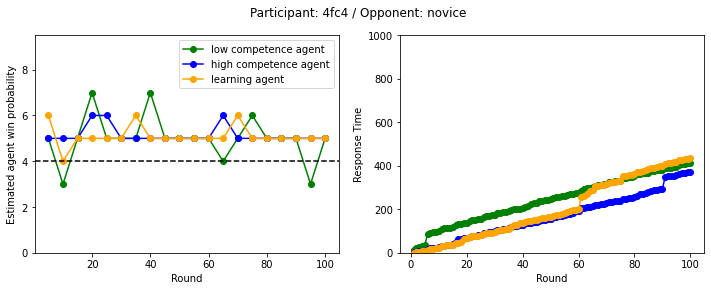

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


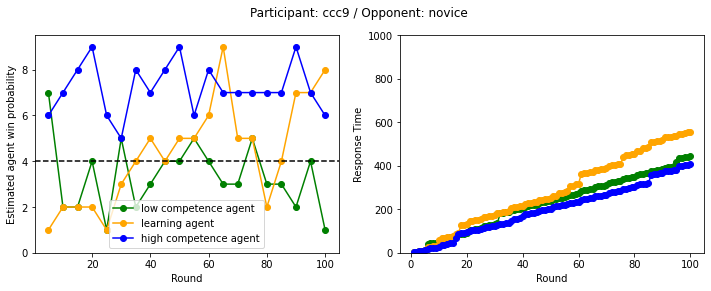

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


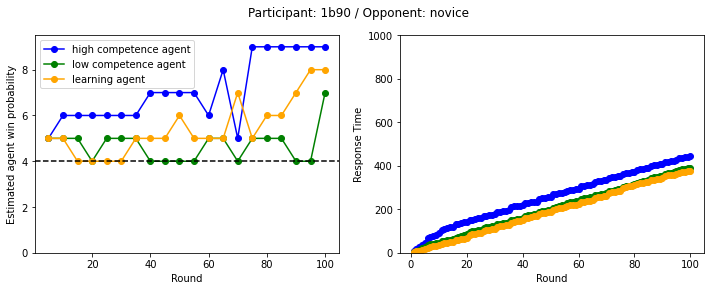

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


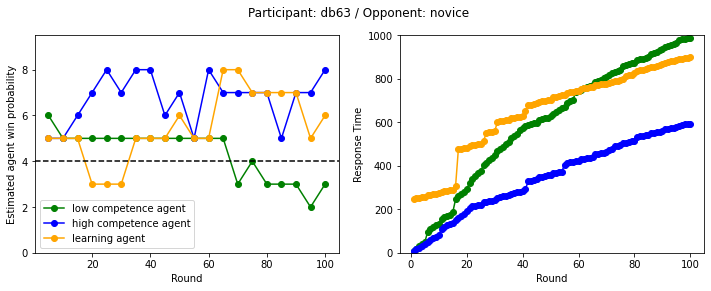

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


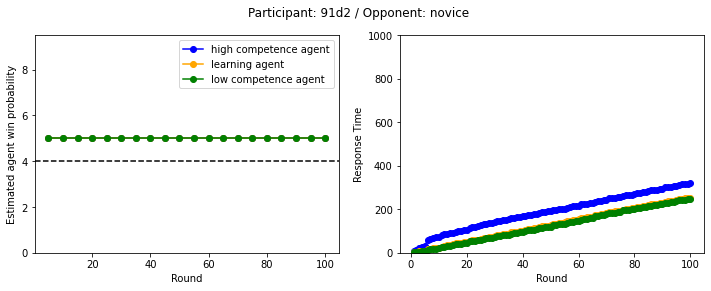

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


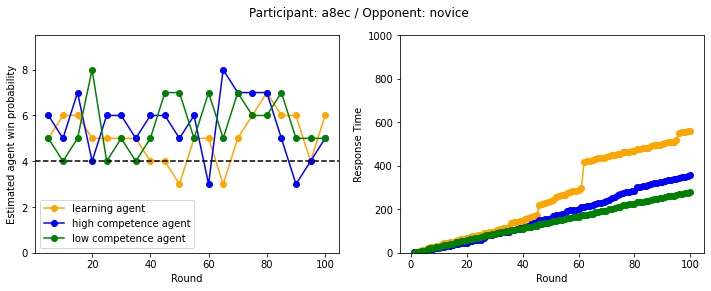

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


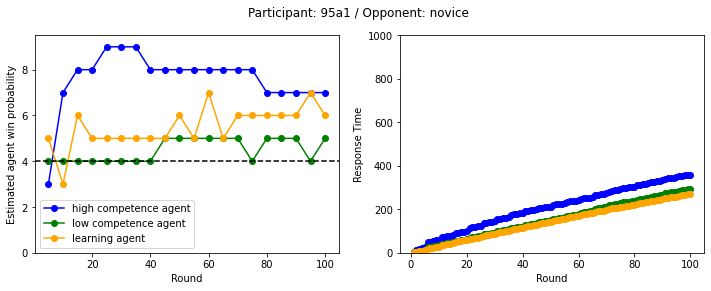

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


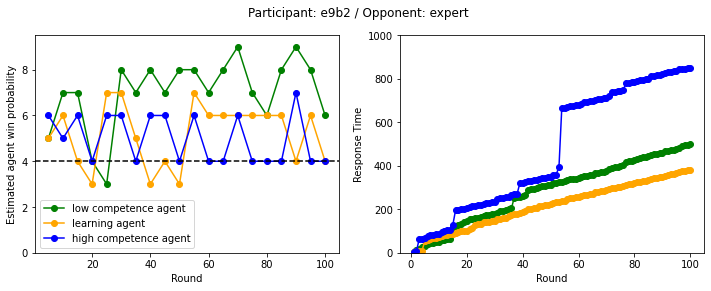

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


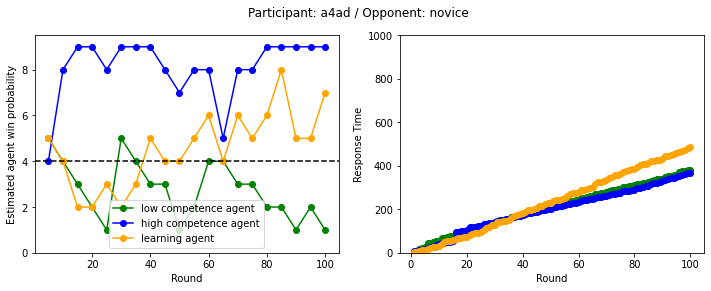

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


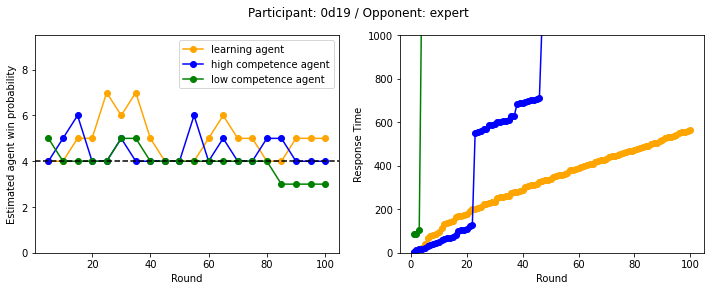

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


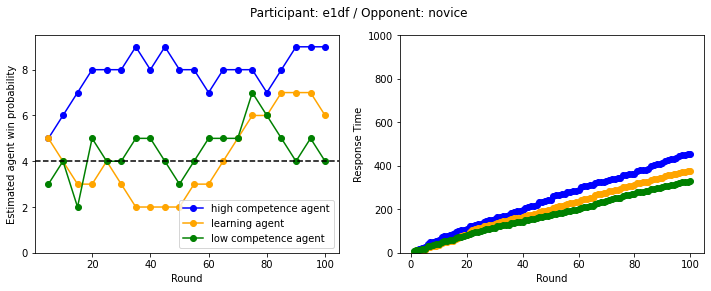

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


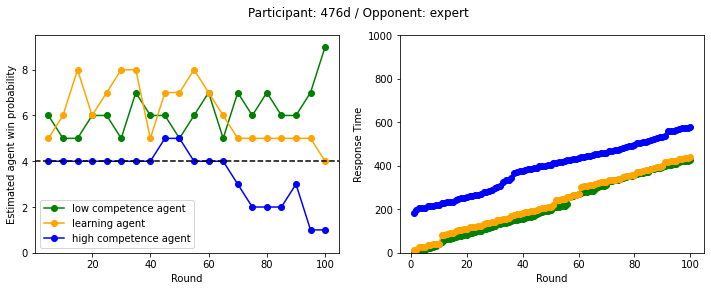

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


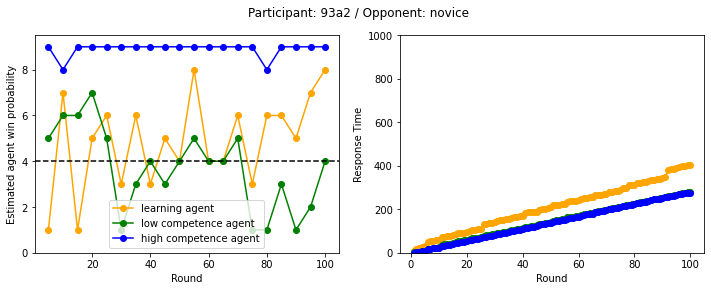

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


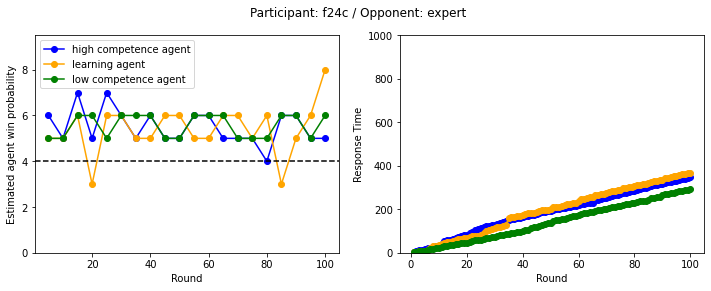

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


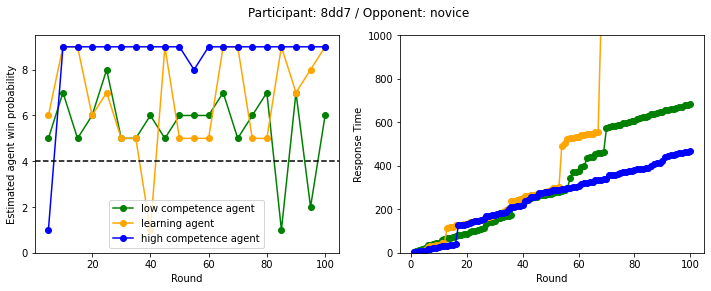

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


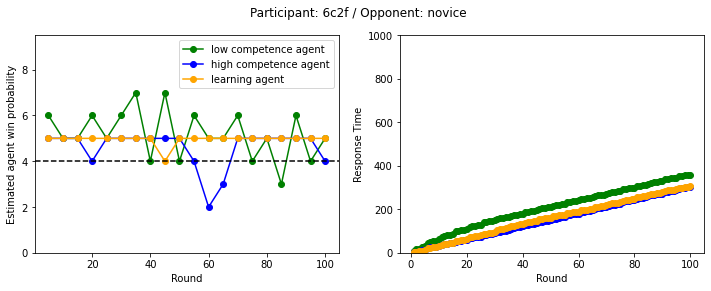

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


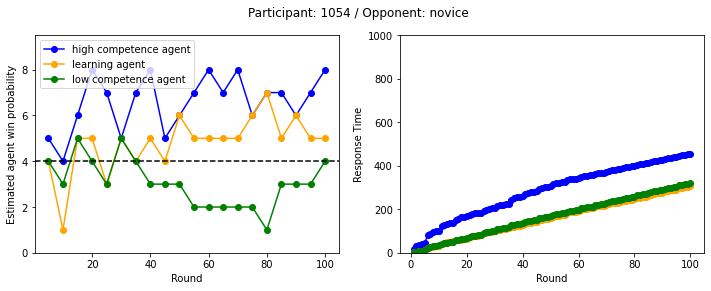

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


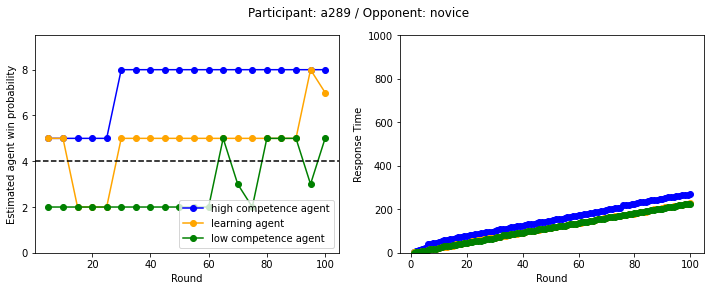

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


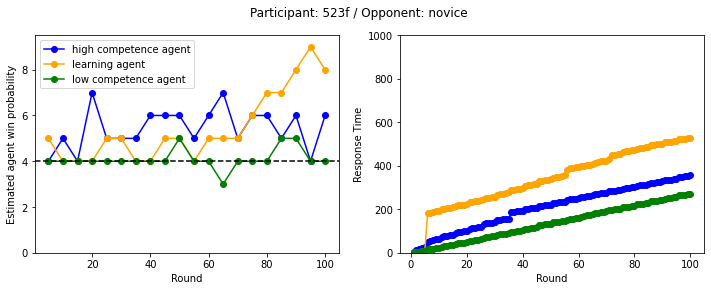

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


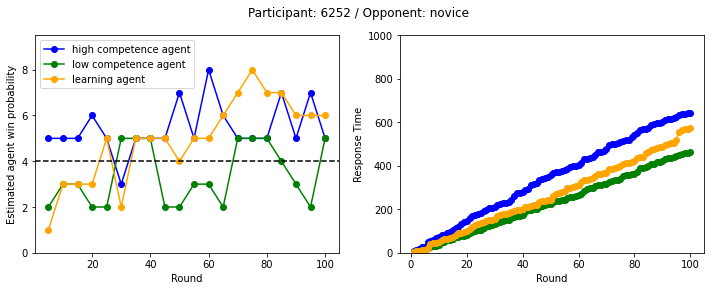

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


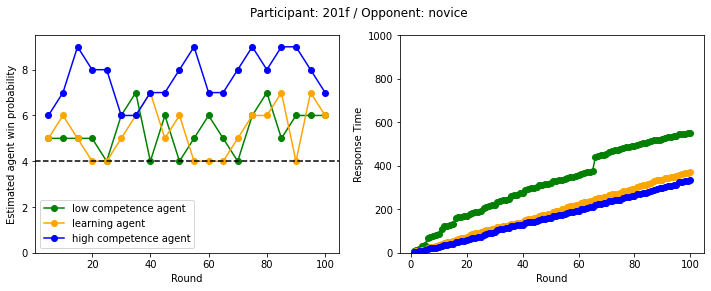

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


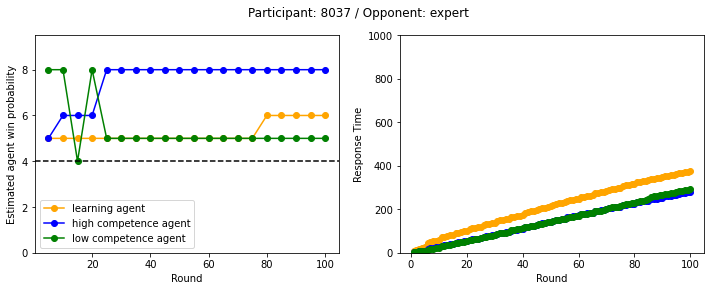

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


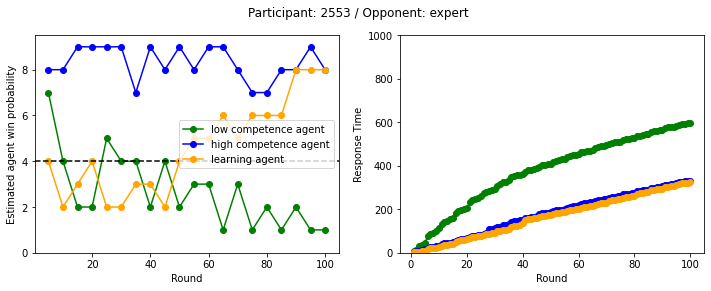

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


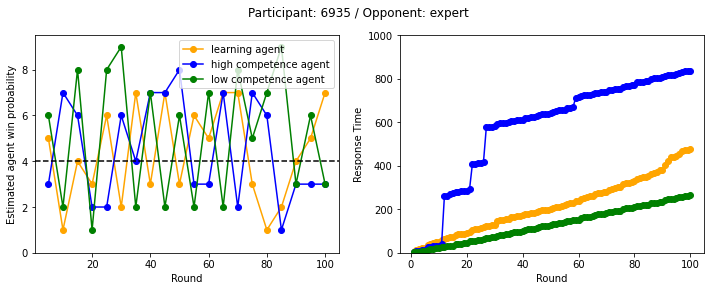

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


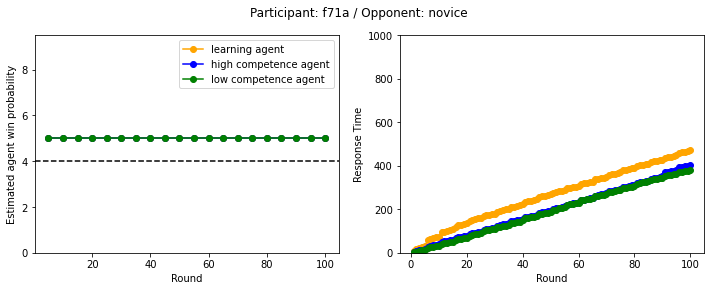

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


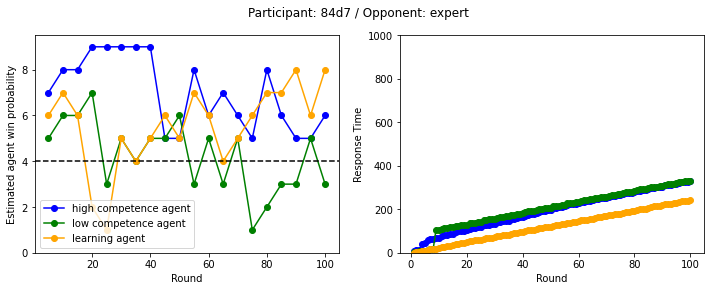

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


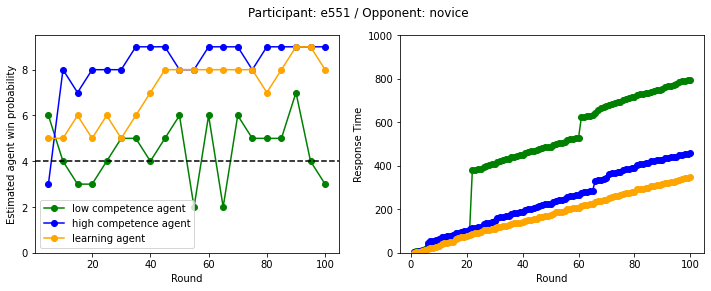

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


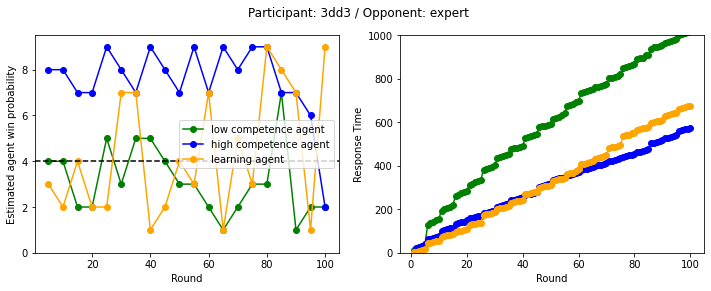

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


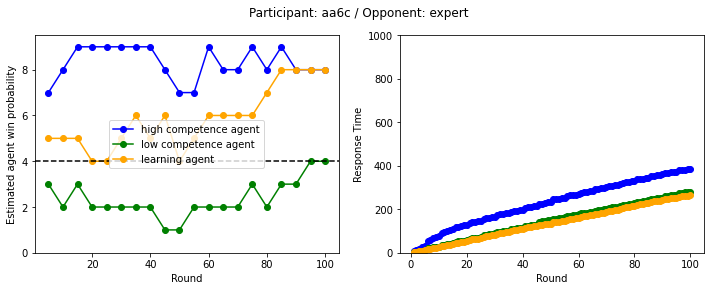

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


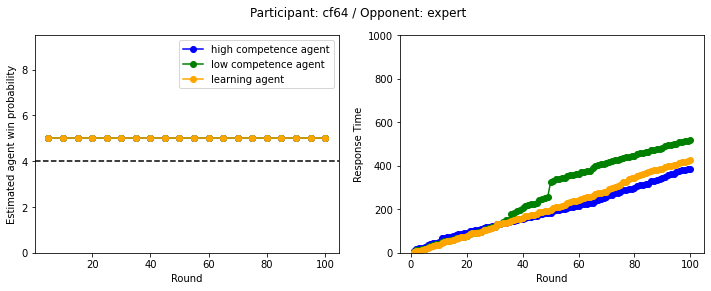

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


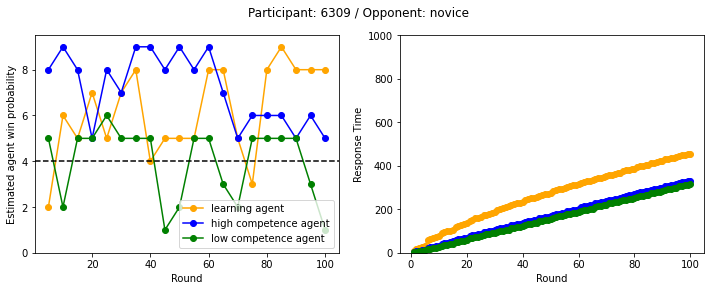

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


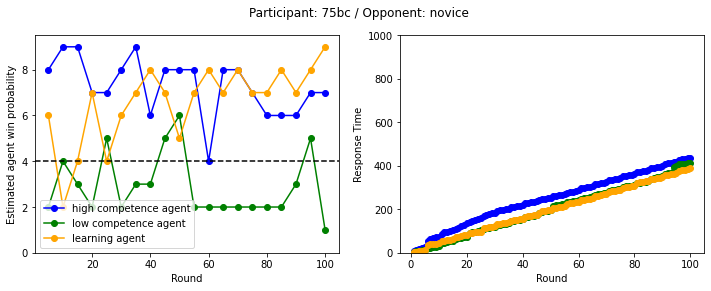

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


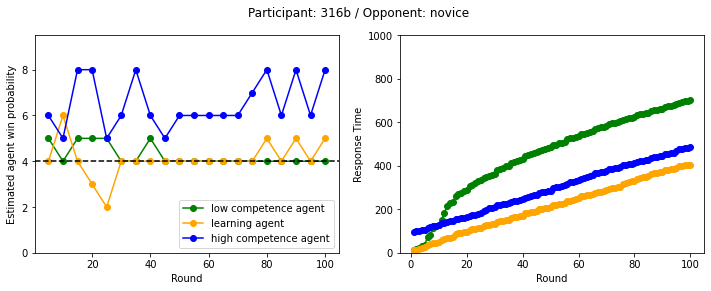

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


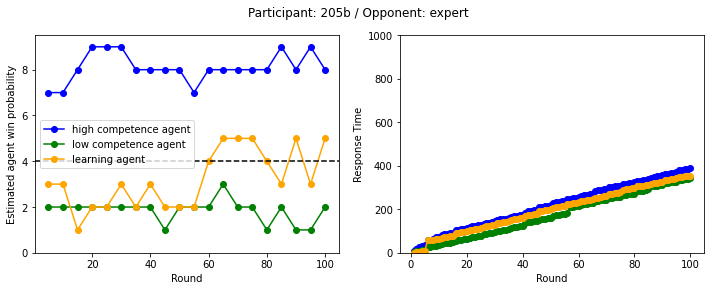

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


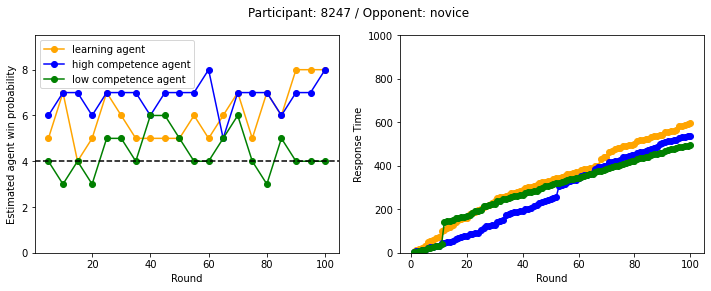

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


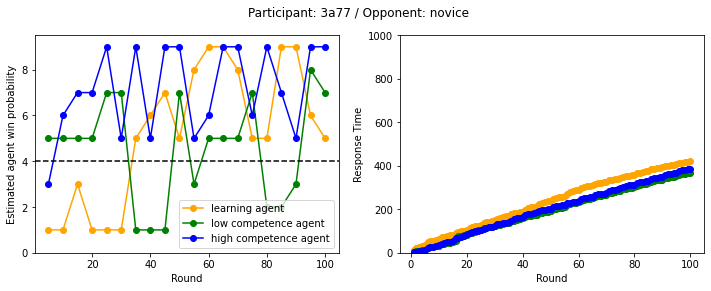

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


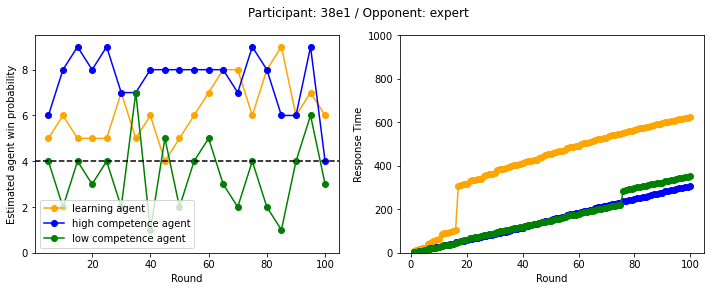

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


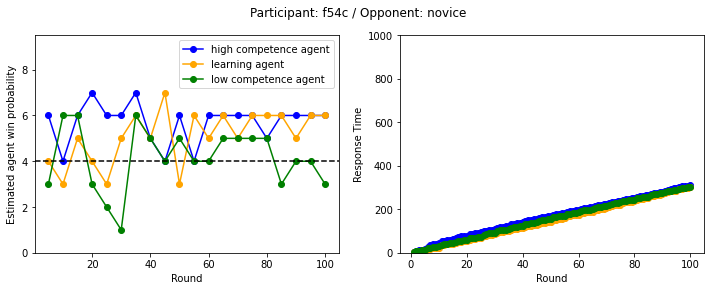

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


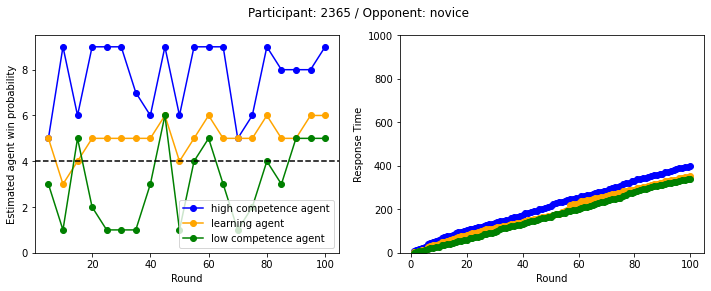

In [238]:
color_dict = {"high competence agent": "blue",
              "learning agent": "orange",
              "low competence agent": "green"}

for client_id, client_data in all_data.items():
    responses = defaultdict(str)
    response_times = defaultdict(str)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for trial_id, trial_data in client_data.items():
        cond = get_condition_str(trial_data)
        opp_type = get_experiment_setting(trial_data)['player2_ability_description']
        responses[cond] = get_responses(trial_data)
        response_times[cond] = get_response_times(trial_data)
        try:
            axs[0].plot(
                responses[cond][:, 0], 
                responses[cond][:, 1], 
                marker='o', label=cond, color=color_dict[cond])
            axs[1].plot(
                response_times[cond][:, 0], 
                response_times[cond][:, 1], 
                marker='o', label=cond, color=color_dict[cond])
        except:
            print(client_id, trial_id)

    plt.suptitle('Participant: {} / Opponent: {}'.format(client_id[-4:], opp_type))
    axs[0].set_xlabel('Round')
    axs[0].set_ylabel('Estimated agent win probability')
    axs[0].axhline(4.0, ls='--', c='black')
    axs[0].set_ylim((0, 9.5))
    axs[0].legend()

    axs[1].set_xlabel('Round')
    axs[1].set_ylabel('Response Time')
    axs[1].set_ylim((0, 1000))

    plt.show()

**Summary**

- At an individual level, people don't seem to strongly differentiate these agents, even in the final blocks.

- Further, it is unclear that they attribute improvement to the learning agent.



## Analysis: individual accuracy

**Questions:**

- How close are people to the ground truth accuracy in their judgments of agent win rates?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=199ccc49-bf50-455b-987a-f3756c1aa6a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>